In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from coffea.util import load
import hist
from pocket_coffea.utils.plot_utils import stack_sum
from pocket_coffea.parameters.lumi import lumi, femtobarn

In [2]:
folder = "/work/mmarcheg/PocketCoffea/output/sf_ele_trigger_semilep/semileptonic_triggerSF_2018_closuretest_withvariations_v01"
folder_plot = os.path.join(folder, "plots/yields")
if not os.path.exists(folder_plot):
    os.makedirs(folder_plot)
filename = os.path.join(folder, "output_{dataset}.coffea")
o = load(filename)
o.keys()

dict_keys(['sum_genweights', 'sumw', 'cutflow', 'variables', 'columns', 'processing_metadata', 'trigger_efficiency', 'scale_genweight'])

In [3]:
o['variables'].keys()

dict_keys(['MuonGood_eta_1', 'MuonGood_pt_1', 'MuonGood_phi_1', 'ElectronGood_pt_1', 'ElectronGood_etaSC_1', 'ElectronGood_phi_1', 'ElectronGood_pt_1_finebinning', 'ElectronGood_etaSC_1_finebinning', 'ElectronGood_phi_1_finebinning', 'JetGood_eta_1', 'JetGood_pt_1', 'JetGood_phi_1', 'JetGood_btagDeepFlavB_1', 'JetGood_eta_2', 'JetGood_pt_2', 'JetGood_phi_2', 'JetGood_btagDeepFlavB_2', 'JetGood_eta_3', 'JetGood_pt_3', 'JetGood_phi_3', 'JetGood_btagDeepFlavB_3', 'JetGood_eta_4', 'JetGood_pt_4', 'JetGood_phi_4', 'JetGood_btagDeepFlavB_4', 'nMuons', 'nElectrons', 'nLeptons', 'nJets', 'nBJets', 'ht', 'electron_etaSC_pt_leading', 'electron_phi_pt_leading', 'electron_etaSC_phi_leading', 'electron_etaSC_pt_all', 'electron_phi_pt_all', 'electron_etaSC_phi_all'])

In [4]:
def get_hist_slice(output, histname, slicing):
    
    # Define Data and MC samples
    samples = output['variables']['electron_etaSC_phi_leading'].keys()
    samples_mc = [s for s in samples if not 'DATA' in s]
    samples_data = [s for s in samples if 'DATA' in s]
    
    # Define data and MC dictionaries to build stacks
    dict_mc = {s : o['variables'][histname][s] for s in samples_mc}
    dict_data = {s : o['variables'][histname][s] for s in samples_data}
    stack_mc = hist.Stack.from_dict(dict_mc)
    stack_data = hist.Stack.from_dict(dict_data)
    
    # Slicing data and MC histograms. MC has an additional axis 'variation'. Data is summed over eras.
    slice_mc = slicing
    slice_data = {k : v for k, v in slicing.items() if not 'variation' in k}
    if type(slicing['cat']) == list:
        h_mc = stack_sum(stack_mc)[slice_mc][sum,:,:,:] # Keep year axis
        h_data = stack_sum(stack_data)[slice_data][sum, :, sum, :, :] # Keep year axis, sum over eras
    else:
        h_mc = stack_sum(stack_mc)[slice_mc][:,:,:] # Keep year axis
        h_data = stack_sum(stack_data)[slice_data][:,sum,:,:] # Keep year axis, sum over eras
    
    return h_mc, h_data

histname = 'electron_etaSC_pt_leading'
#histname = 'electron_etaSC_phi_leading'
#transpose = False

transpose = {'electron_etaSC_pt_leading' : False, 'electron_etaSC_phi_leading' : True}
vmin_dict = {'electron_etaSC_pt_leading' : 50.0, 'electron_etaSC_phi_leading' : 100.0}
vmax_dict = {'electron_etaSC_pt_leading' : 300.0, 'electron_etaSC_phi_leading' : 180.0}

In [5]:
h_mc, h_data = get_hist_slice(o, histname, {'cat' : 'Ele32_EleHT_pass', 'variation' : 'nominal'})
h_mc_passfail, h_data_passfail = get_hist_slice(o, histname, {'cat' : ['Ele32_EleHT_pass', 'Ele32_EleHT_fail'], 'variation' : 'nominal'})
h_mc_sfapplied, h_data_sfapplied = get_hist_slice(o, histname, {'cat' : 'Ele32_EleHT_pass_triggerSF', 'variation' : 'nominal'})

/work/mmarcheg/miniconda3/envs/pocket-coffea-blank/lib/python3.8/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


In [6]:
fontsize_map = 18
fontsize = 18
rotation = 90

opts_gap = {
    "step": "post",
    #"color": (0, 0, 0, 0.4),
    "color": "white",
    "facecolor": "white",
    #"linewidth": 0,
    "hatch": '/' * 100,
    "zorder": 2,
}

def plot_yields(h, title=None, rnd=0, transpose=False, vmin=vmin_dict[histname], vmax=vmax_dict[histname], file_plot=None, label="Counts", **kwargs):
    if 'year' in kwargs:
        year = kwargs['year']
    if 'label' in kwargs:
        label = kwargs['label']
        h.label = label
    if len(h.axes.name) == 3:
        if not 'year' in h.axes.name:
            raise Exception("The axis 'year' must be present in the axes.")
        else:
            axis_year = h.axes[0]
        if not axis_year.size == 1:
            raise NotImplemented
        else:
            year = axis_year.value(0)
            h = h[{'year' : year}]
    elif len(h.axes.name) == 2:
        pass
    else:
        raise Exception("Wrong number of histogram axes.")
    
    fig, ax = plt.subplots(1,1, figsize=[16,10])
    axis_x = h.axes[0]
    axis_y = h.axes[1]
    values = h.values()[()]
    if transpose:
        axis_x = h.axes[1]
        axis_y = h.axes[0]
        y, x = np.meshgrid(axis_y.centers, axis_x.centers)
        fields = {
            axis_x.name : x.flatten(),
            axis_y.name : y.flatten(),
        }
        # We define a new histogram by swapping the order of the x,y axes
        # and filling it with the tranposed yields
        values = values.transpose()
        h = hist.Hist(axis_x, axis_y)
        h.fill(**fields, weight=values)
    h.plot2d(ax=ax, vmin=vmin, vmax=vmax);
    if title != None:
        ax.set_title(title)
    varname_x = axis_x.name
    varname_y = axis_y.name
    
    hep.cms.text("Preliminary", loc=0, ax=ax)
    hep.cms.lumitext(
        text=f'{femtobarn(lumi[year]["tot"], digits=1)}'
        + r' fb$^{-1}$, 13 TeV,'
        + f' {year}',
        fontsize=18,
        ax=ax,
    )
    if varname_x == 'ElectronGood.pt':
        ax.set_xscale('log')

    xticks = axis_x.edges
    yticks = axis_y.edges
    ax.xaxis.label.set_size(fontsize)
    ax.yaxis.label.set_size(fontsize)
    
    if varname_x == 'ElectronGood.pt':
        ax.set_xticks(xticks, [str(int(t)) for t in xticks], fontsize=fontsize)
    elif varname_x == 'ElectronGood.etaSC':
        ax.set_xticks(xticks, [str(round(t,4)) for t in xticks], fontsize=fontsize, rotation=rotation)
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='minor',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True)  # labels along the bottom edge are off

    ax.set_yticks(
        yticks, [str(round(t, 4)) for t in yticks], fontsize=fontsize
    )
    ax.tick_params(
        axis='y',          # changes apply to the y-axis
        which='minor',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True)  # labels along the bottom edge are off
    ax.set_xlim(axis_x.edges[0], axis_x.edges[-1])
    ax.set_ylim(axis_y.edges[0], axis_y.edges[-1])
    plt.vlines(
        axis_x.edges,
        axis_y.edges[-1],
        axis_y.edges[0],
        linestyle='--',
        color='gray',
    )
    plt.hlines(
        axis_y.edges,
        axis_x.edges[-1],
        axis_x.edges[0],
        linestyle='--',
        color='gray',
    )
    
    if varname_y == 'ElectronGood.etaSC':
        for gap in [(-1.5660, -1.4442), (1.4442, 1.5660)]:
            ax.fill_between([xticks[0], xticks[-1]], *gap, **opts_gap) #label="ECAL gap",)
    if varname_x == 'ElectronGood.etaSC':
        for gap in [(-1.5660, -1.4442), (1.4442, 1.5660)]:
            ax.fill_between(list(gap), yticks[0], yticks[-1], **opts_gap) #label="ECAL gap",)
    
    for (i, x) in enumerate(axis_x.centers):
        if (x < ax.get_xlim()[0]) | (x > ax.get_xlim()[1]):
            continue
        if varname_x == "ElectronGood.etaSC":
            if (abs(x) > 1.4442) & (abs(x) < 1.5660):
                continue
        for (j, y) in enumerate(axis_y.centers):
            color = "w"
            if varname_y == "ElectronGood.etaSC":
                if (abs(y) > 1.4442) & (abs(y) < 1.5660):
                    continue
                else:
                    ax.text(
                        x,
                        y,
                        [f"{int(values[i][j])}" if rnd==0 else f"{round(values[i][j], rnd)}"][0],
                        color=color,
                        ha="center",
                        va="center",
                        fontsize=fontsize_map,
                        fontweight="bold",
                    )
            else:
                ax.text(
                    x,
                    y,
                    [f"{int(values[i][j])}" if rnd==0 else f"{round(values[i][j], rnd)}"][0],
                    color=color,
                    ha="center",
                    va="center",
                    fontsize=fontsize_map,
                    fontweight="bold",
                )
    if not file_plot == None:
        plt.tight_layout()
        fig.savefig(file_plot, dpi=300, format="png")

    return h
                
def plot_ratio(num, den, title=None, transpose=False, vmin=0.8, vmax=1.4, file_plot=None, label="Ratio"):
    if (len(num.axes.name) != 3) | (len(den.axes.name) != 3):
        raise NotImplemented
    if (not 'year' in num.axes.name) | (not 'year' in den.axes.name):
        raise NotImplemented
    else:
        axis_year = num.axes[0]
    if not axis_year.size == 1:
        raise NotImplemented
    else:
        year = axis_year.value(0)
        num = num[{'year' : year}]
        den = den[{'year' : year}]

    axis_x = num.axes[0]
    axis_y = num.axes[1]
    
    #r = np.nan_to_num(num.values() / den.values(), 0)
    r = np.nan_to_num(num.values() / den.values(), 0)
    
    y, x = np.meshgrid(axis_y.centers, axis_x.centers)
    fields = {
        axis_x.name : x.flatten(),
        axis_y.name : y.flatten(),
    }
    ratio = hist.Hist(axis_x, axis_y)
    ratio.fill(**fields, weight=r)

    return plot_yields(ratio, title=title, rnd=2, transpose=transpose, vmin=vmin, vmax=vmax, file_plot=file_plot, label=label, year=year)

# Closure test of trigger SF
## Trigger SF
The application of the trigger Scale Factor aims at matching the trigger efficiency in MC simulation to the one measured in data. In general, the number of MC events after application of the SF is not necessarily equal to the number of events in data. The SF is defined as:

\begin{align}
    SF = \frac{\epsilon_{data}}{\epsilon_{MC}} \tag{1}
\end{align}

where the efficiency $\epsilon$ is defined as:

\begin{align}
    \epsilon = \frac{N_p}{N_0} = \frac{N_p}{N_p + N_f} \tag{2}
\end{align}

where $N_p$ and $N_f$ stand for the number of events passing and failing the trigger requirement, respectively, and $N_0$ is their sum.

## Effect of trigger SF on MC yields
The effect of the SF on the number of MC events in the trigger pass selection is the following:

\begin{align}
    \label{eq:n_mc_sf_effect}
    N_{MC,pass} \longrightarrow\;& SF \times N_{MC,pass} \tag{3} \\
    =& \frac{N_{data,pass}}{N_{MC,pass}} \cdot \frac{N_{MC,pass}+N_{MC,fail}}{N_{data,pass}+N_{data,fail}} \times N_{MC,pass} \tag{4} \\
    =& N_{data,pass} \cdot \frac{N_{MC,pass}+N_{MC,fail}}{N_{data,pass}+N_{data,fail}} \tag{5} \\
    =& N_{data,pass} \cdot \mathcal{R} \tag{6}
\end{align}

where we defined as $\mathcal{R}$ the multiplicative factor to get the corrected MC yields given the data yields $N_{data,pass}$.

## Closure test
We want to check explicitely that the corrected MC yields correspond to the data yields multiplied by $\mathcal{R}$. To do so, we compare the corrected MC yields as computed in (3) with the MC yields computed a posteriori with (6).

### Trigger pass+fail, no SF applied
First, we compute the MC and data yields in the pass+fail region, with no SF applied:

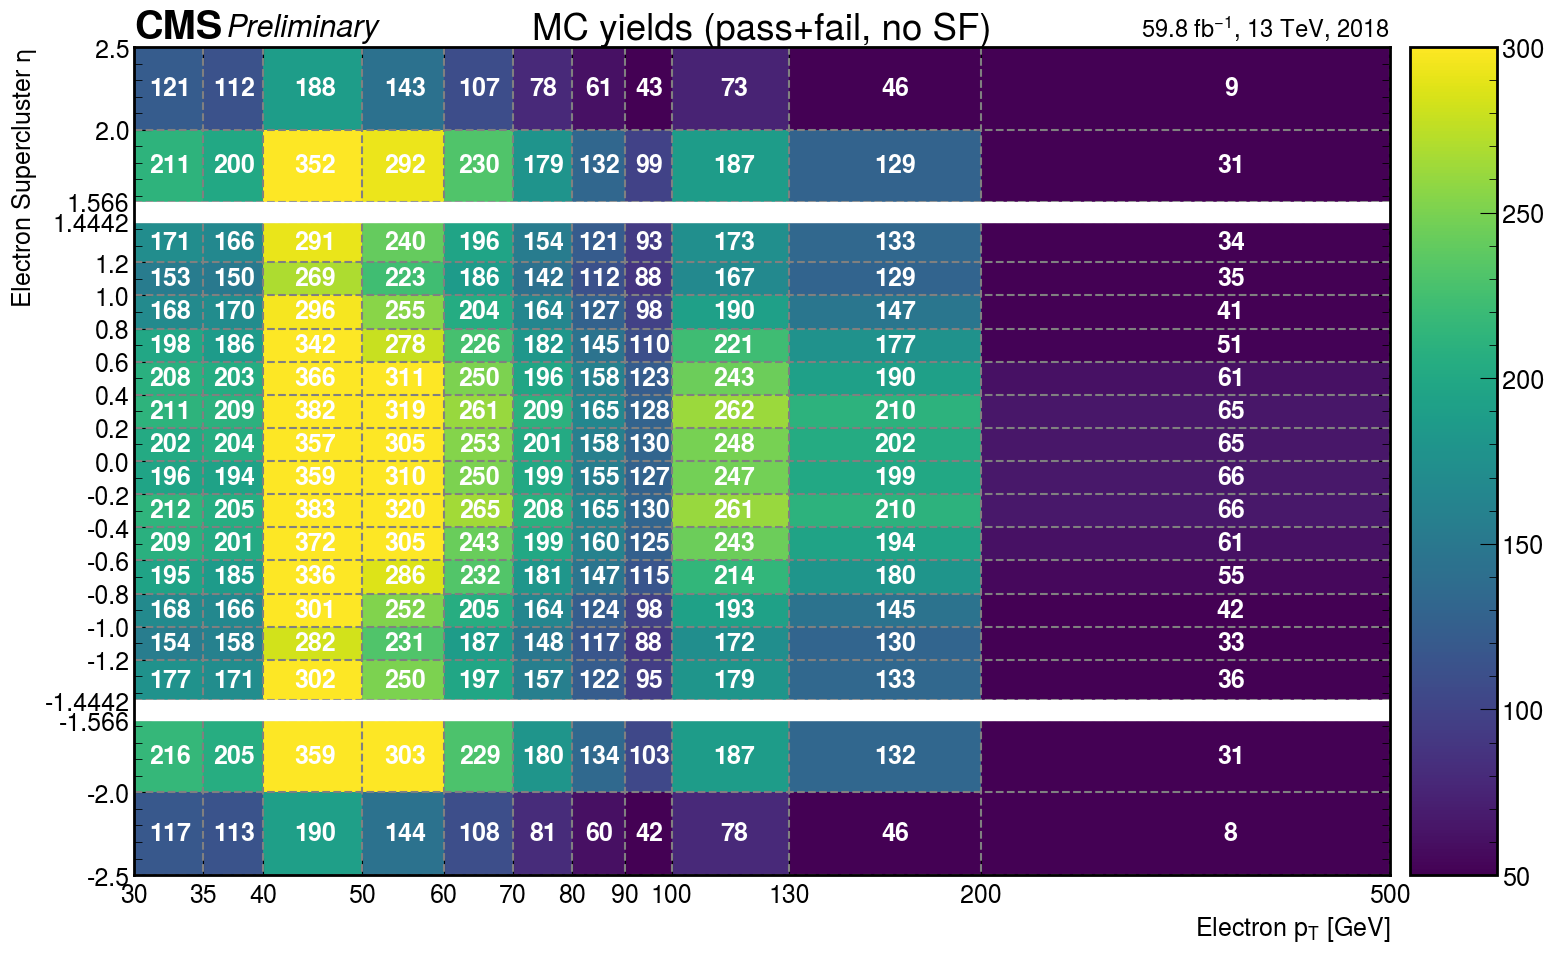

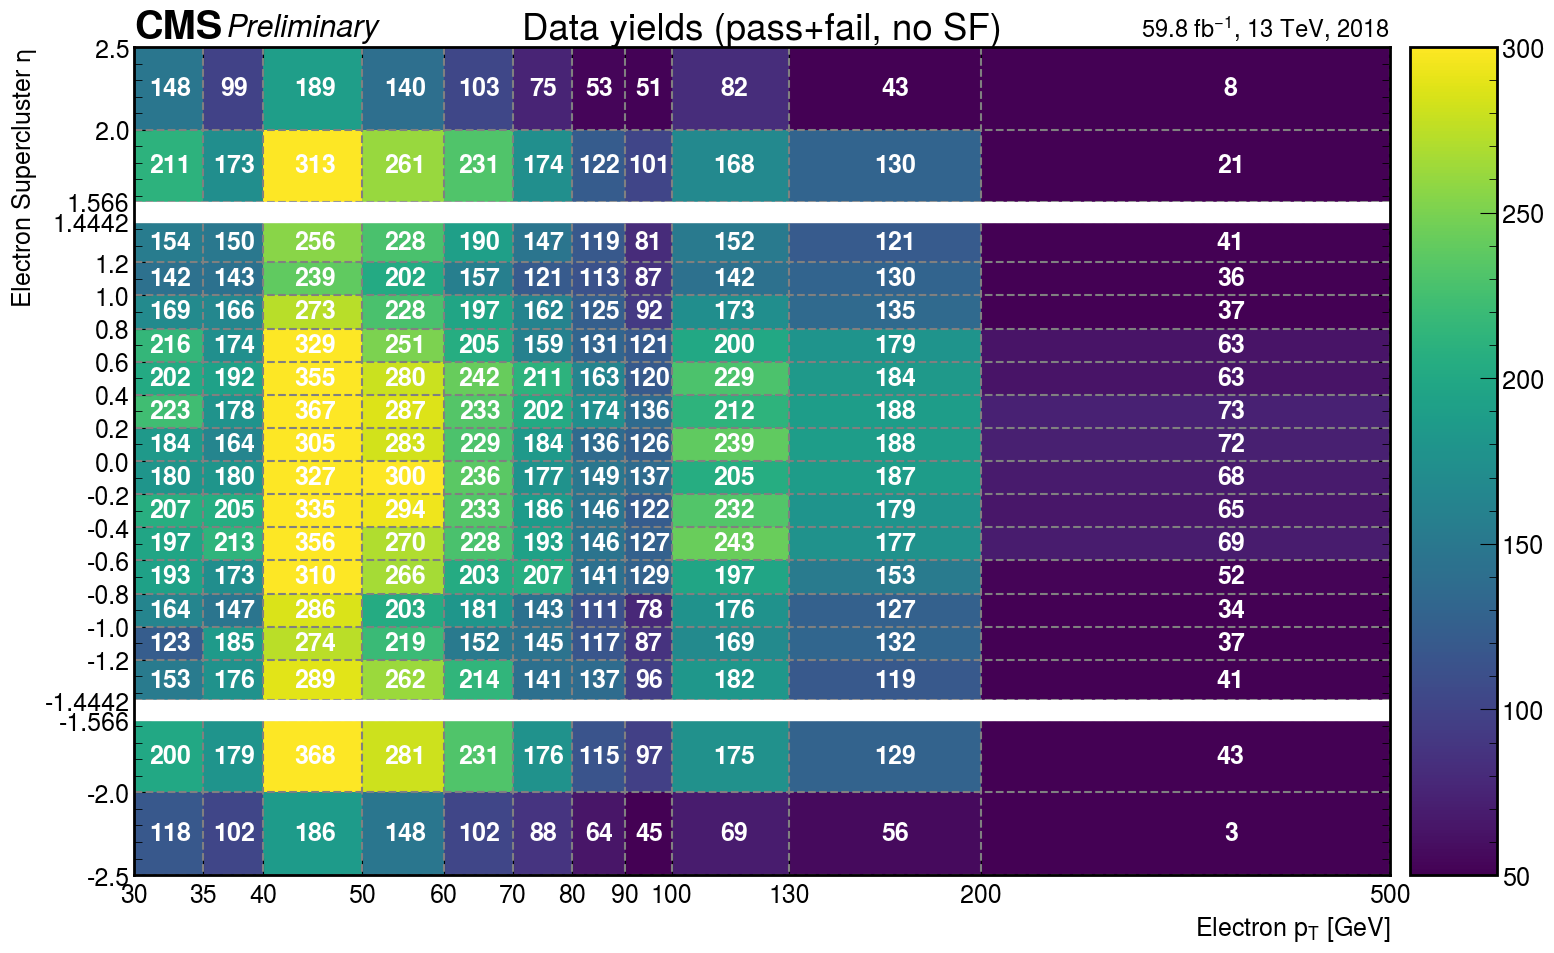

In [7]:
categories = ['mc_passfail', 'data_passfail']
yields = {}
for map2d, title, cat in zip([h_mc_passfail, h_data_passfail], ['MC yields (pass+fail, no SF)', 'Data yields (pass+fail, no SF)'], categories):
    file_plot = os.path.join(folder_plot, f"{histname}_yields_{cat}.png")
    yields[cat] = plot_yields(map2d, title, transpose=transpose[histname], file_plot=file_plot)

### Trigger pass, no SF applied
Secondly, we compute the MC and data yields in the pass region, with no SF applied:

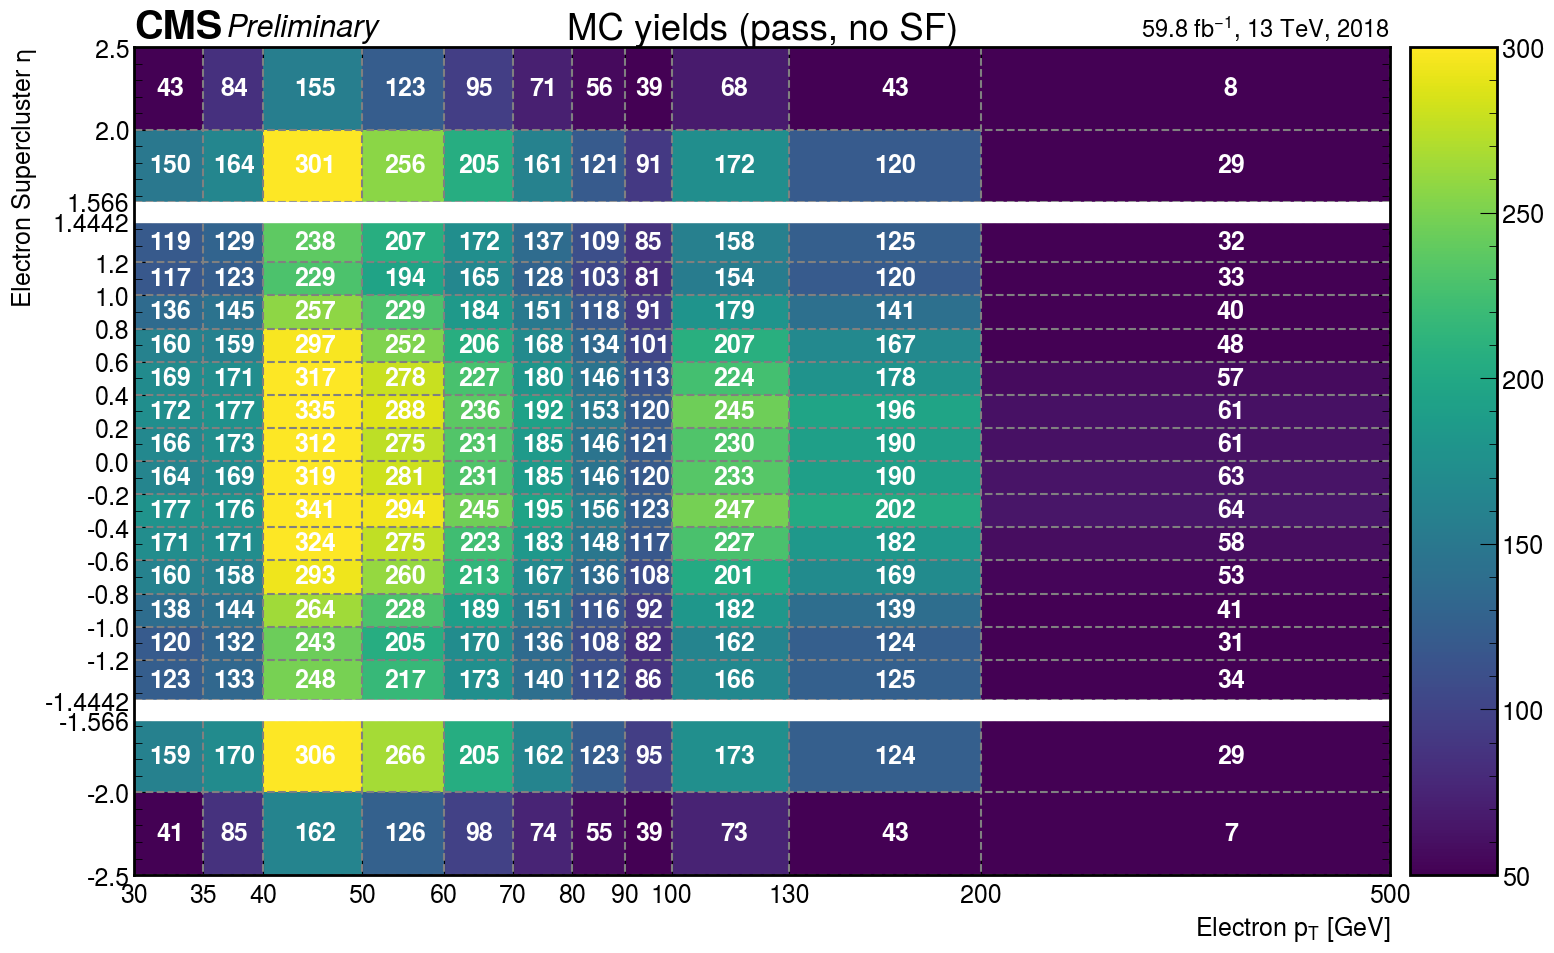

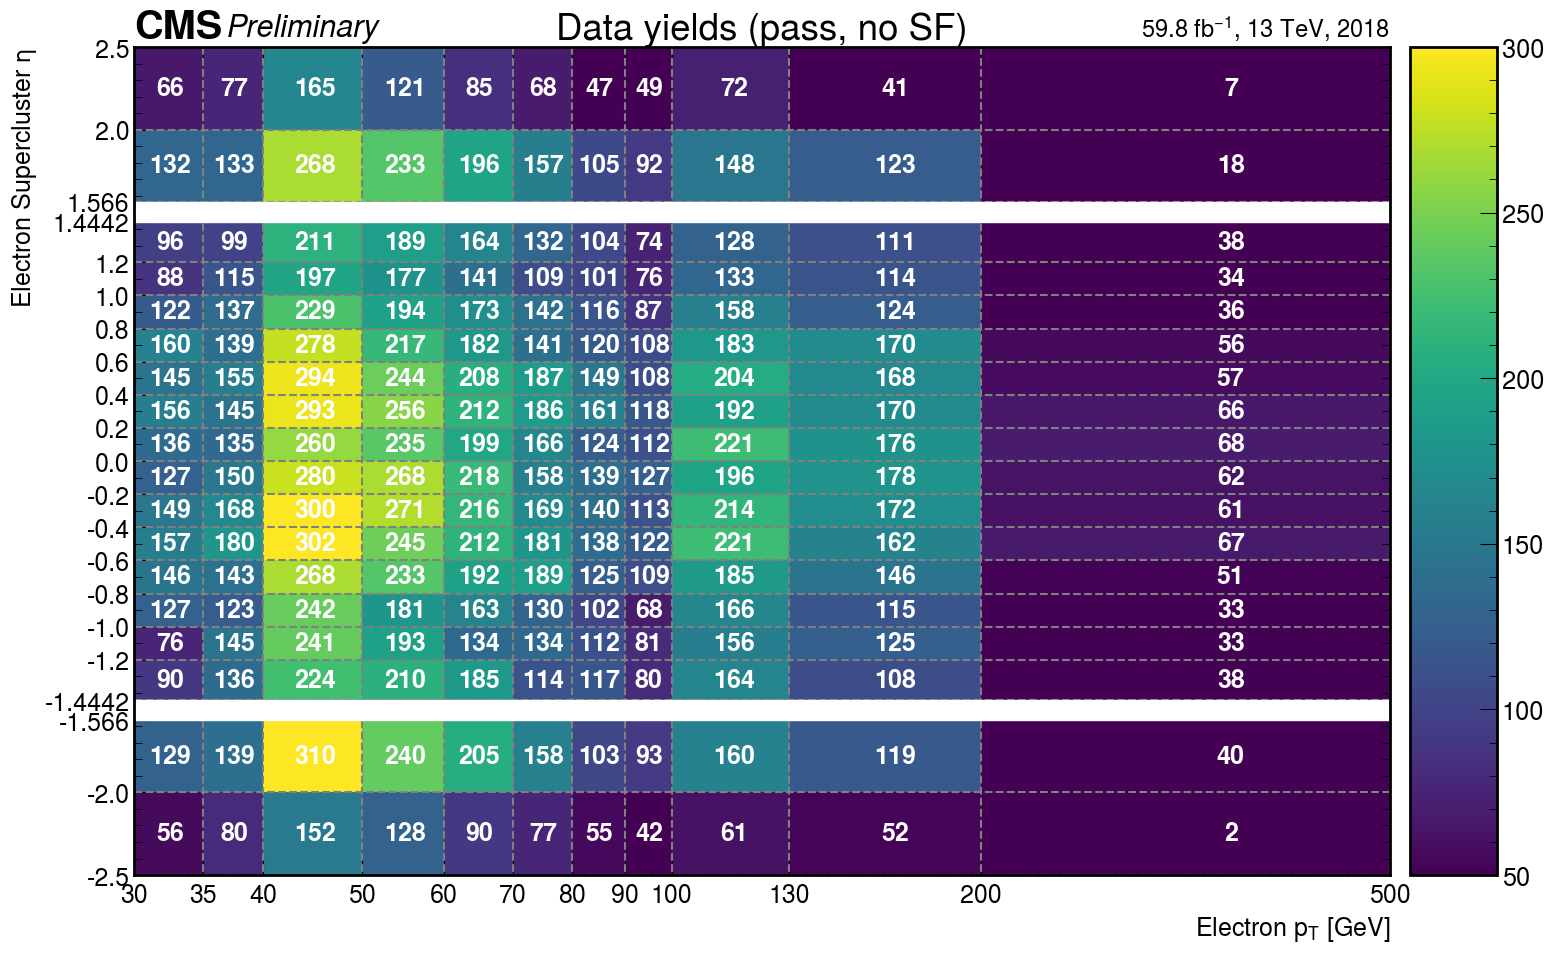

In [8]:
categories = ['mc_pass', 'data_pass']
for map2d, title, cat in zip([h_mc, h_data], ['MC yields (pass, no SF)', 'Data yields (pass, no SF)'], categories):
    file_plot = os.path.join(folder_plot, f"{histname}_yields_{cat}.png")
    yields[cat] = plot_yields(map2d, title, transpose=transpose[histname], file_plot=file_plot)

### Compute $\mathcal{R}$
Then, we compute the multiplicative factor $\mathcal{R}$ by considering the MC and data yields in the pass and fail regions:

/tmp/ipykernel_61565/4265375335.py:176: RuntimeWarning: invalid value encountered in true_divide
  r = np.nan_to_num(num.values() / den.values(), 0)


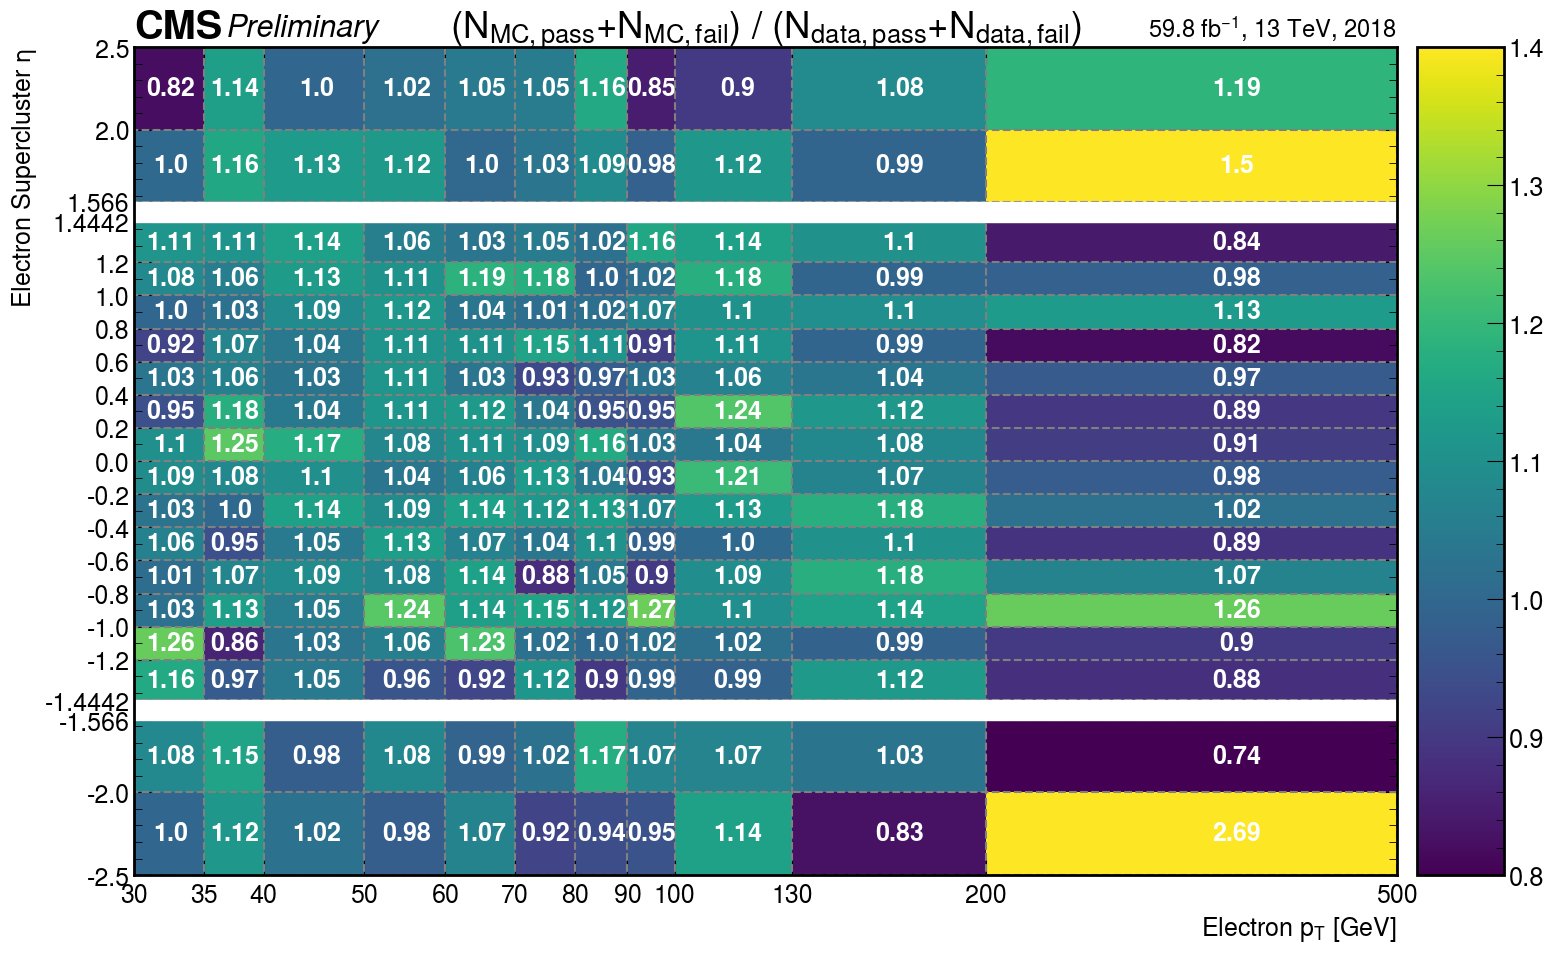

In [9]:
file_plot = os.path.join(folder_plot, f"{histname}_ratio_nominal.png")
ratio_mc_data_passfail = plot_ratio(h_mc_passfail, h_data_passfail, title="($N_{MC,pass}$+$N_{MC,fail})$ / ($N_{data,pass}$+$N_{data,fail}$)", transpose=transpose[histname], file_plot=file_plot)

### Trigger pass, SF applied
We compute the corrected MC yields as defined in (3). As a cross-check, also the data yields are reported in this category despite no difference with the data yields in the uncorrected category is expected:

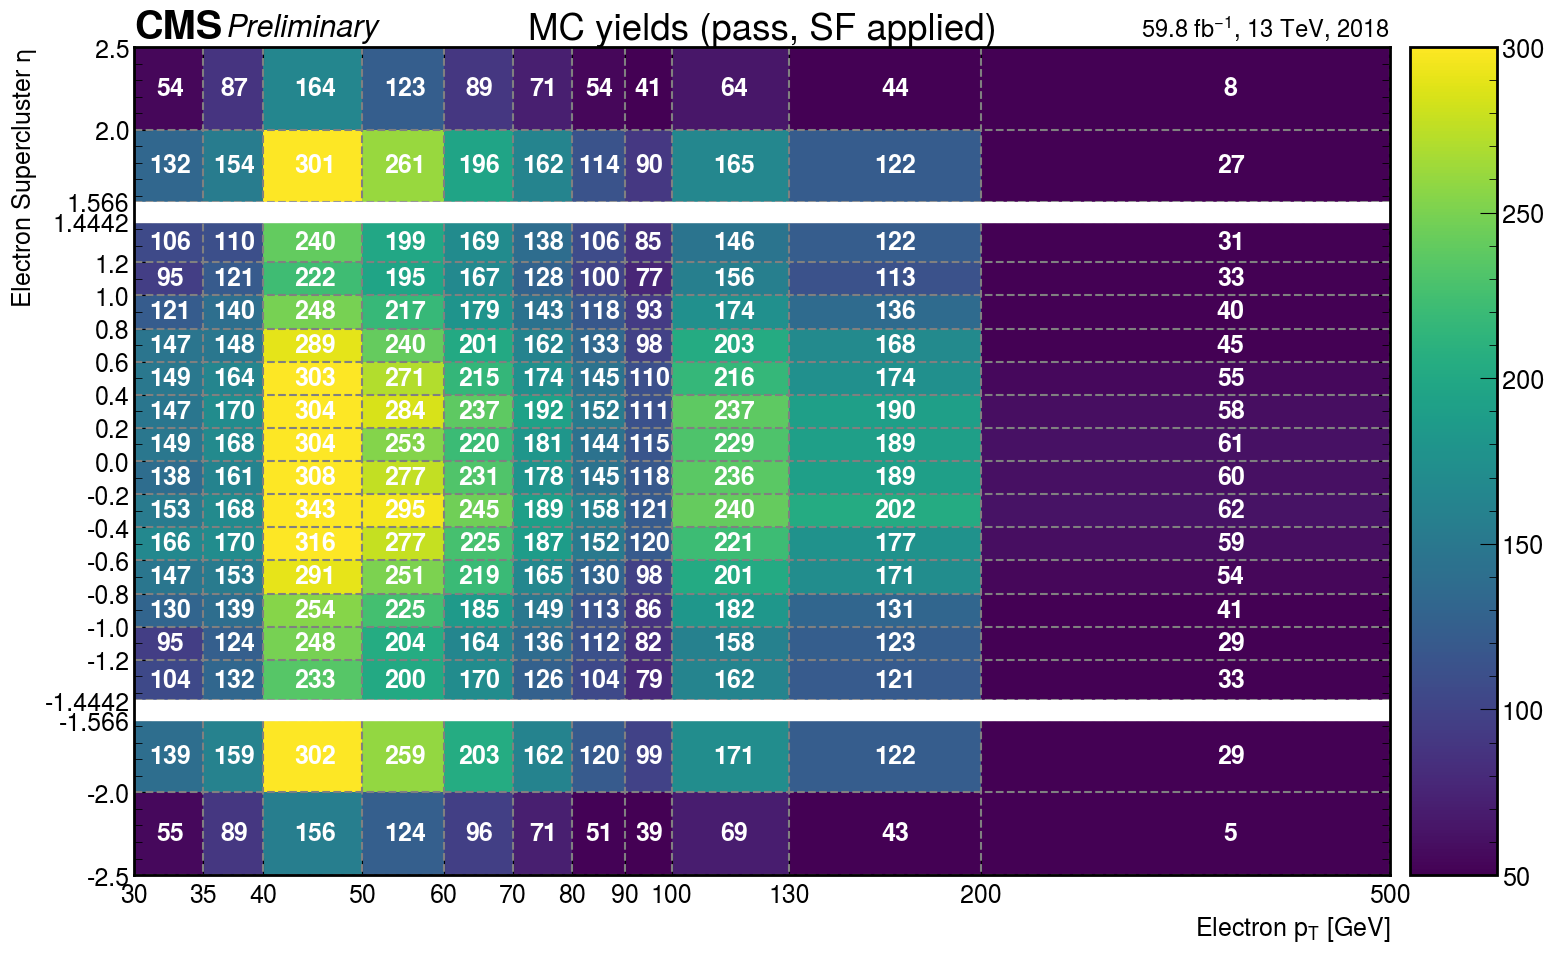

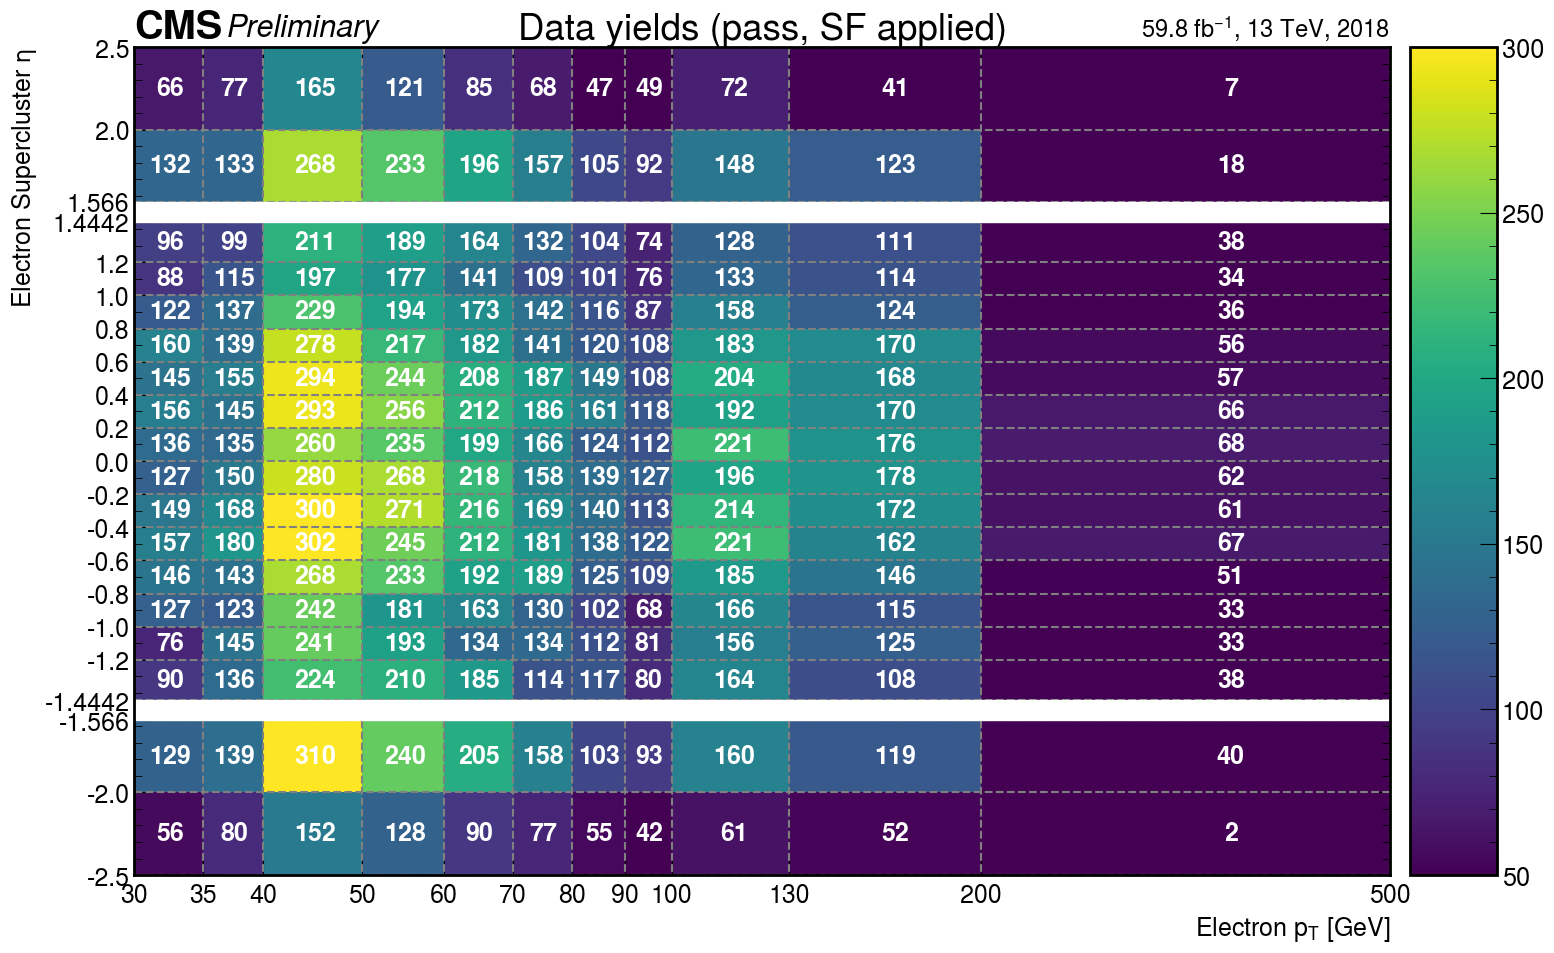

In [10]:
categories = ['mc_pass_sfapplied', 'data_pass_sfapplied']
for map2d, title, cat in zip([h_mc_sfapplied, h_data_sfapplied], ['MC yields (pass, SF applied)', 'Data yields (pass, SF applied)'], categories):
    file_plot = os.path.join(folder_plot, f"{histname}_yields_{cat}.png")
    yields[cat] = plot_yields(map2d, title, transpose=transpose[histname], file_plot=file_plot)

In [11]:
yields

{'mc_passfail': Hist(
   Variable([30, 35, 40, 50, 60, 70, 80, 90, 100, 130, 200, 500], name='ElectronGood.pt', label='Electron $p_{T}$ [GeV]'),
   Variable([-2.5, -2, -1.566, -1.4442, -1.2, -1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4442, 1.566, 2, 2.5], name='ElectronGood.etaSC', label='Electron Supercluster $\\eta$'),
   storage=Weight()) # Sum: WeightedSum(value=35189.4, variance=1219.66) (WeightedSum(value=35194.7, variance=1219.86) with flow),
 'data_passfail': Hist(
   Variable([30, 35, 40, 50, 60, 70, 80, 90, 100, 130, 200, 500], name='ElectronGood.pt', label='Electron $p_{T}$ [GeV]'),
   Variable([-2.5, -2, -1.566, -1.4442, -1.2, -1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4442, 1.566, 2, 2.5], name='ElectronGood.etaSC', label='Electron Supercluster $\\eta$'),
   storage=Weight()) # Sum: WeightedSum(value=33124, variance=33124) (WeightedSum(value=33134, variance=33134) with flow),
 'mc_pass': Hist(
   Variable([30, 35, 40, 50, 60, 70, 80, 90,

### Compute corrected MC yields
Finally, we compute the corrected MC yields as defined in (6), by multiplying the data yields in the pass region by the multiplicative factor $\mathcal{R}$:

In [12]:
#h_mc_calibrated = yields['data_pass']*ratio_mc_data_passfail
#h_mc_calibrated

### Comparison of ratios
We can now compare the ratio of the SF-corrected number of events $N_{MC,pass}$ and $N_{data,pass}$ with the ratio $\mathcal{R}$ as defined in (6):

/tmp/ipykernel_61565/4265375335.py:176: RuntimeWarning: invalid value encountered in true_divide
  r = np.nan_to_num(num.values() / den.values(), 0)


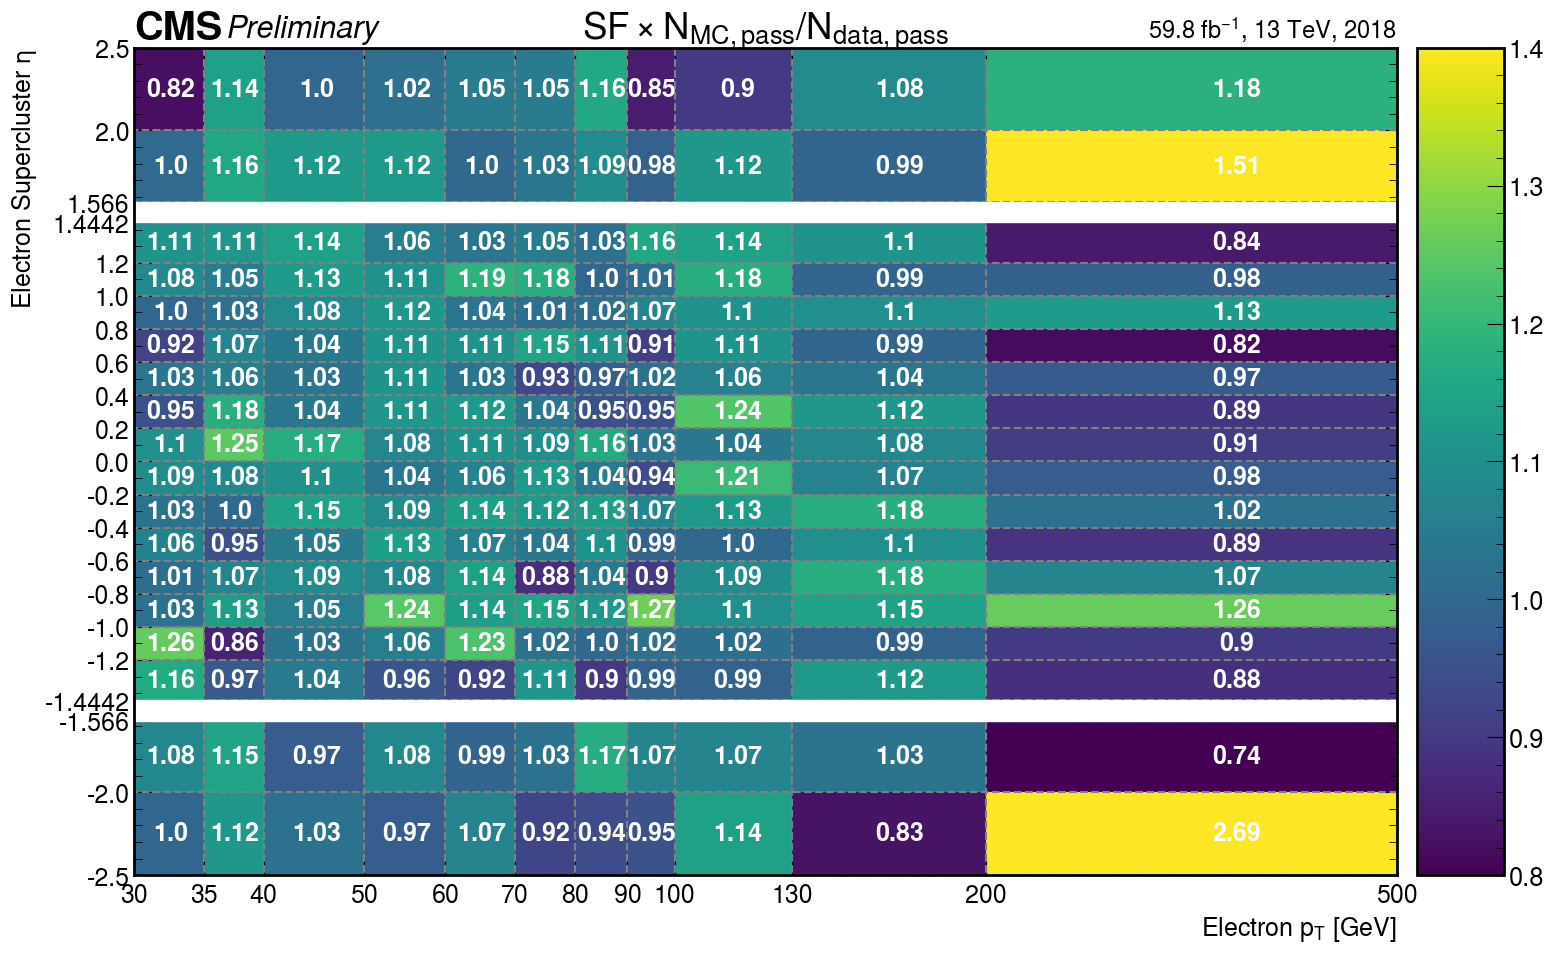

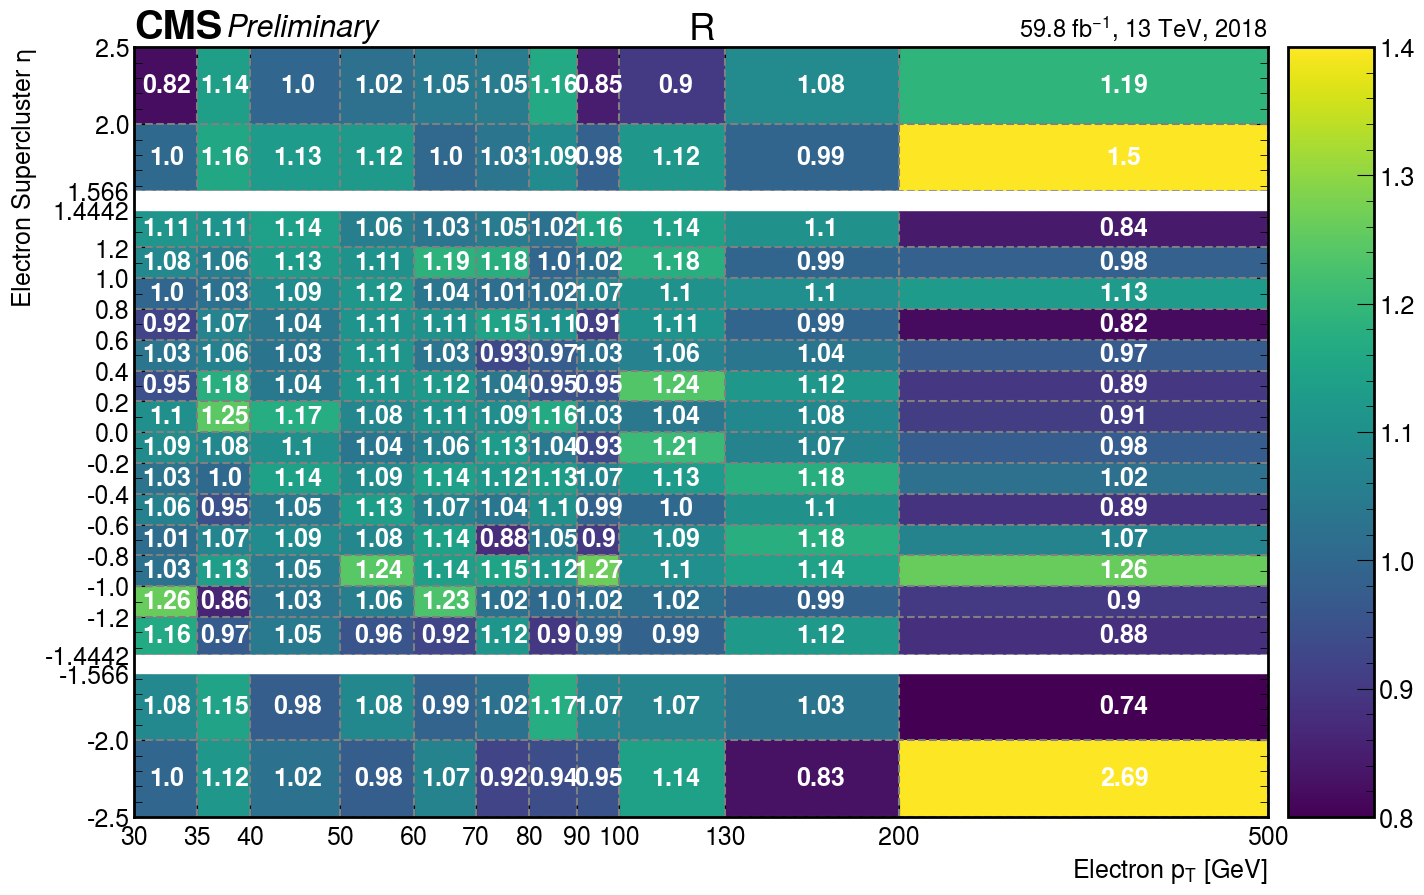

In [13]:
#_h = plot_yields(h_mc_calibrated, "MC yields (pass, calibrated)")
#_h = plot_yields(h_mc_sfapplied, "MC yields (pass, SF applied)", transpose=transpose)
file_plot = os.path.join(folder_plot, f"{histname}_ratio_calibrated.png")
r_calibrated = plot_ratio(h_mc_sfapplied, h_data_sfapplied, "$SF\\times N_{MC,pass}/N_{data,pass}$", transpose=transpose[histname], file_plot=file_plot)
#file_plot = os.path.join(folder_plot, f"{histname}_ratio_nominal.png")
r_nominal = plot_ratio(h_mc_passfail, h_data_passfail, "$\mathcal{R}$", transpose=transpose[histname])

In [14]:
histname = 'electron_etaSC_phi_leading'

h_mc, h_data = get_hist_slice(o, histname, {'cat' : 'Ele32_EleHT_pass', 'variation' : 'nominal'})
h_mc_passfail, h_data_passfail = get_hist_slice(o, histname, {'cat' : ['Ele32_EleHT_pass', 'Ele32_EleHT_fail'], 'variation' : 'nominal'})
h_mc_sfapplied, h_data_sfapplied = get_hist_slice(o, histname, {'cat' : 'Ele32_EleHT_pass_triggerSF', 'variation' : 'nominal'})

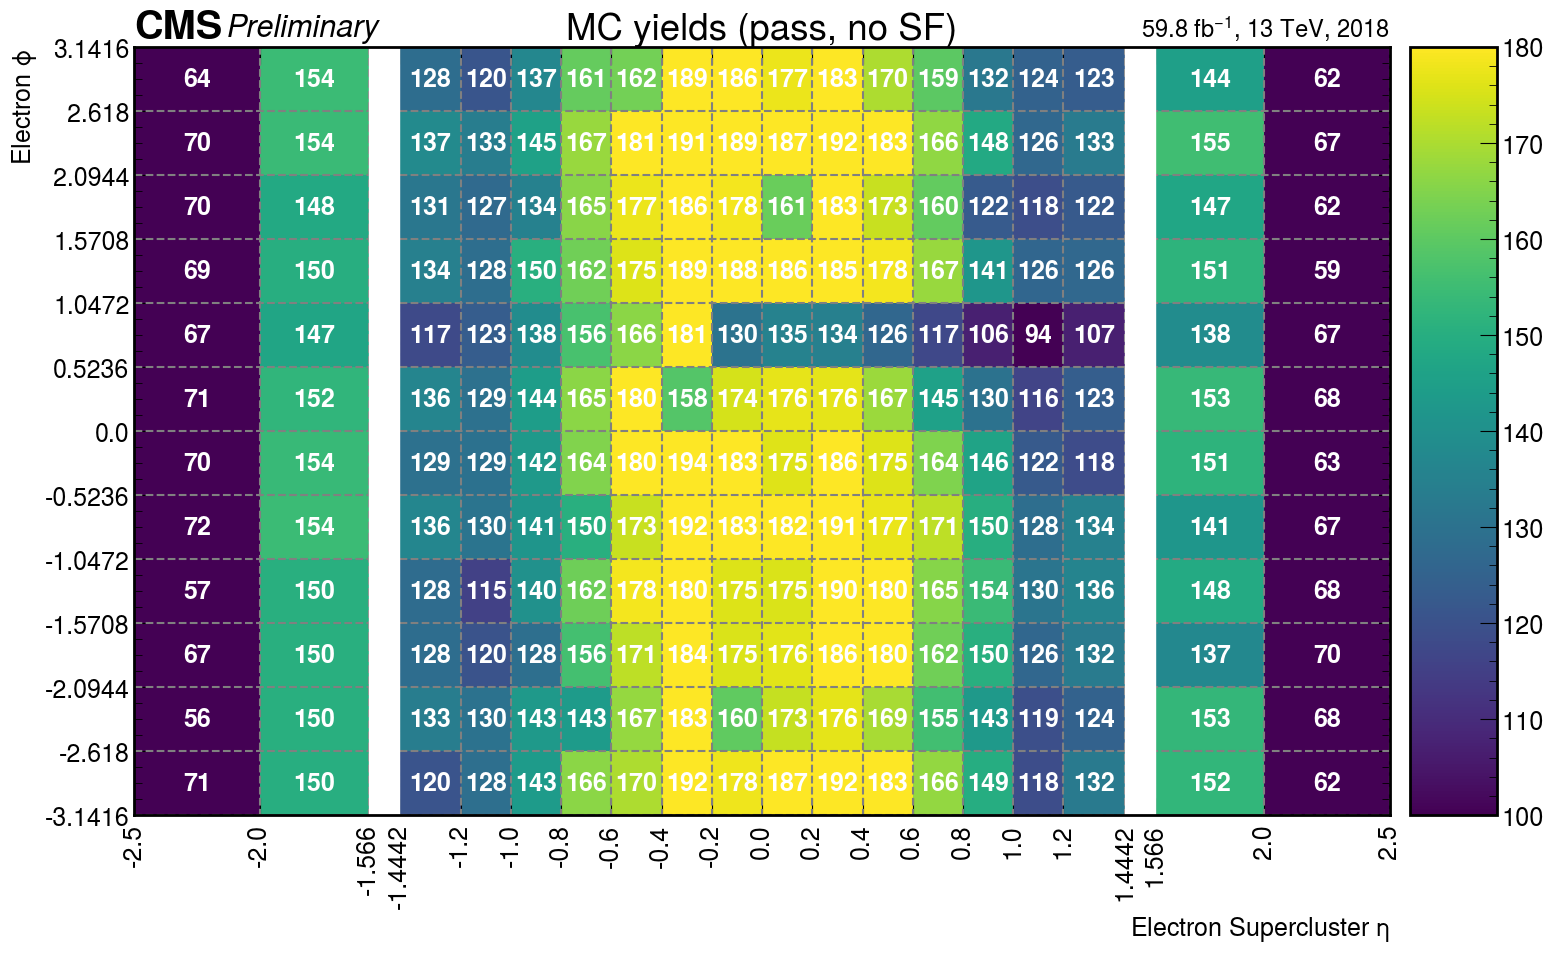

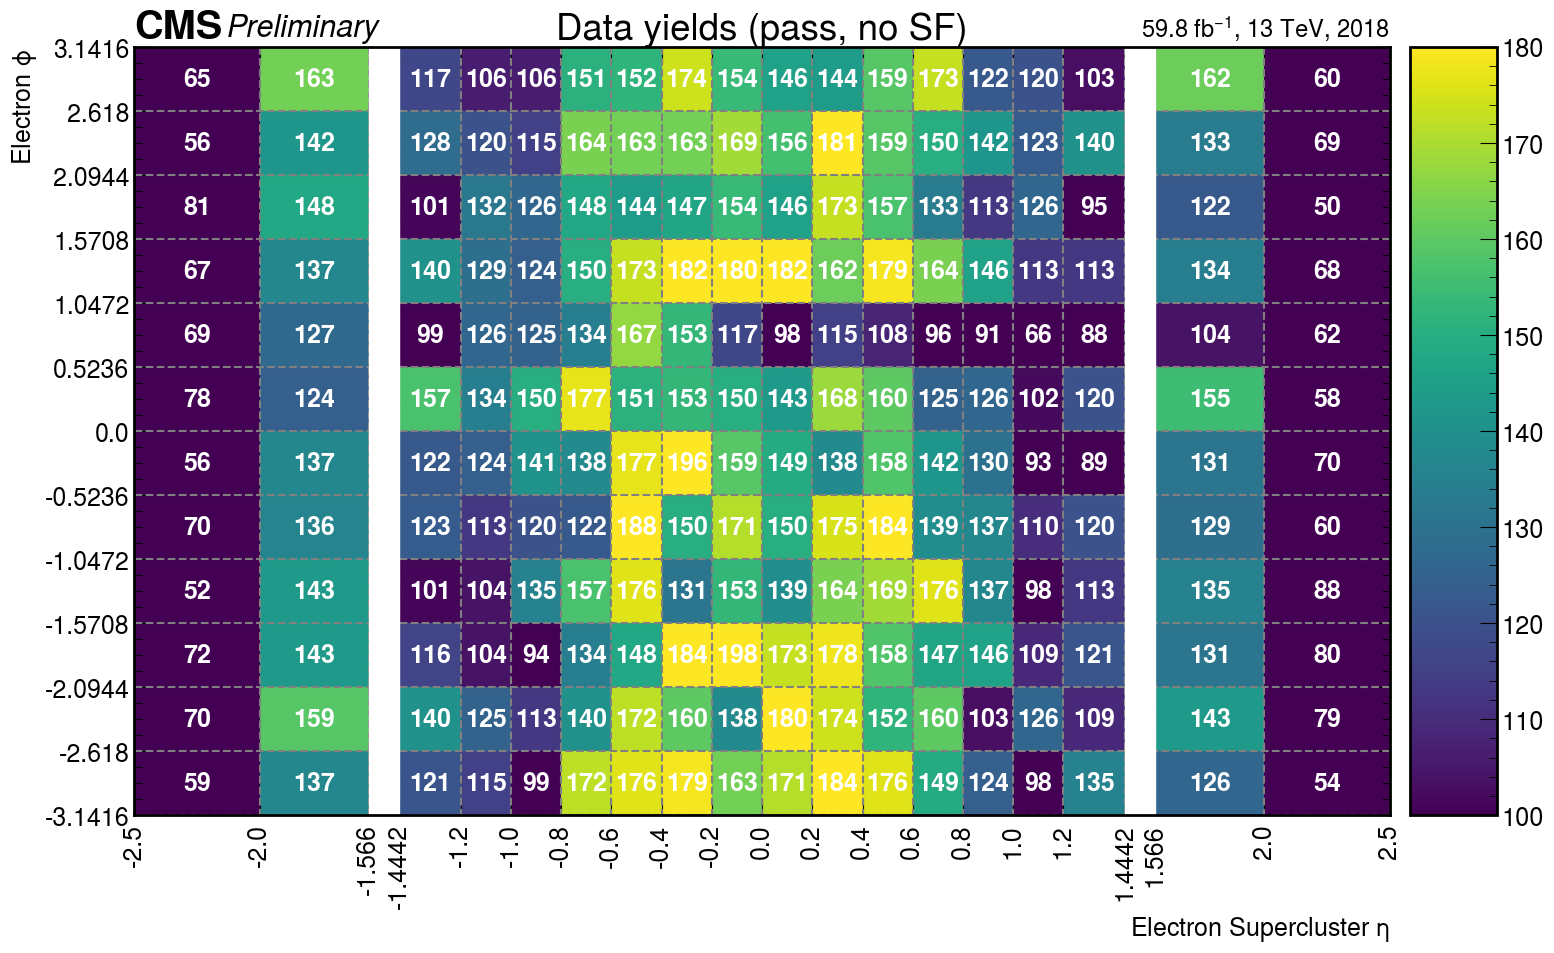

In [15]:
categories = ['mc_pass', 'data_pass']
for map2d, title, cat in zip([h_mc, h_data], ['MC yields (pass, no SF)', 'Data yields (pass, no SF)'], categories):
    file_plot = os.path.join(folder_plot, f"{histname}_yields_{cat}.png")
    yields[cat] = plot_yields(map2d, title, transpose=transpose[histname], vmin=vmin_dict[histname], vmax=vmax_dict[histname], file_plot=file_plot)

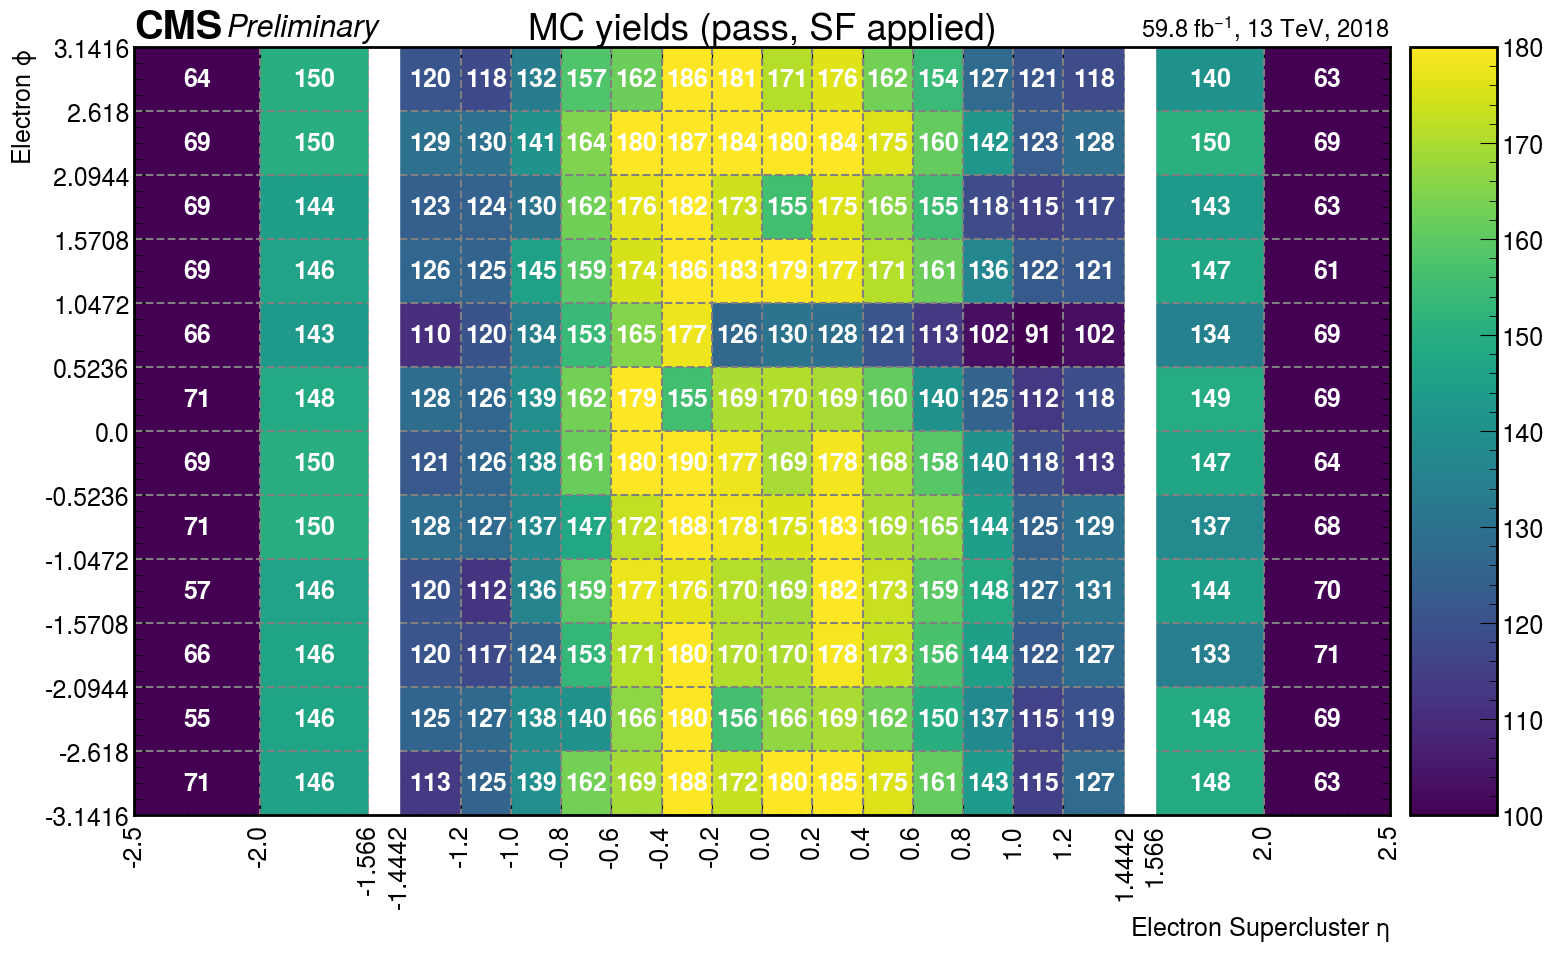

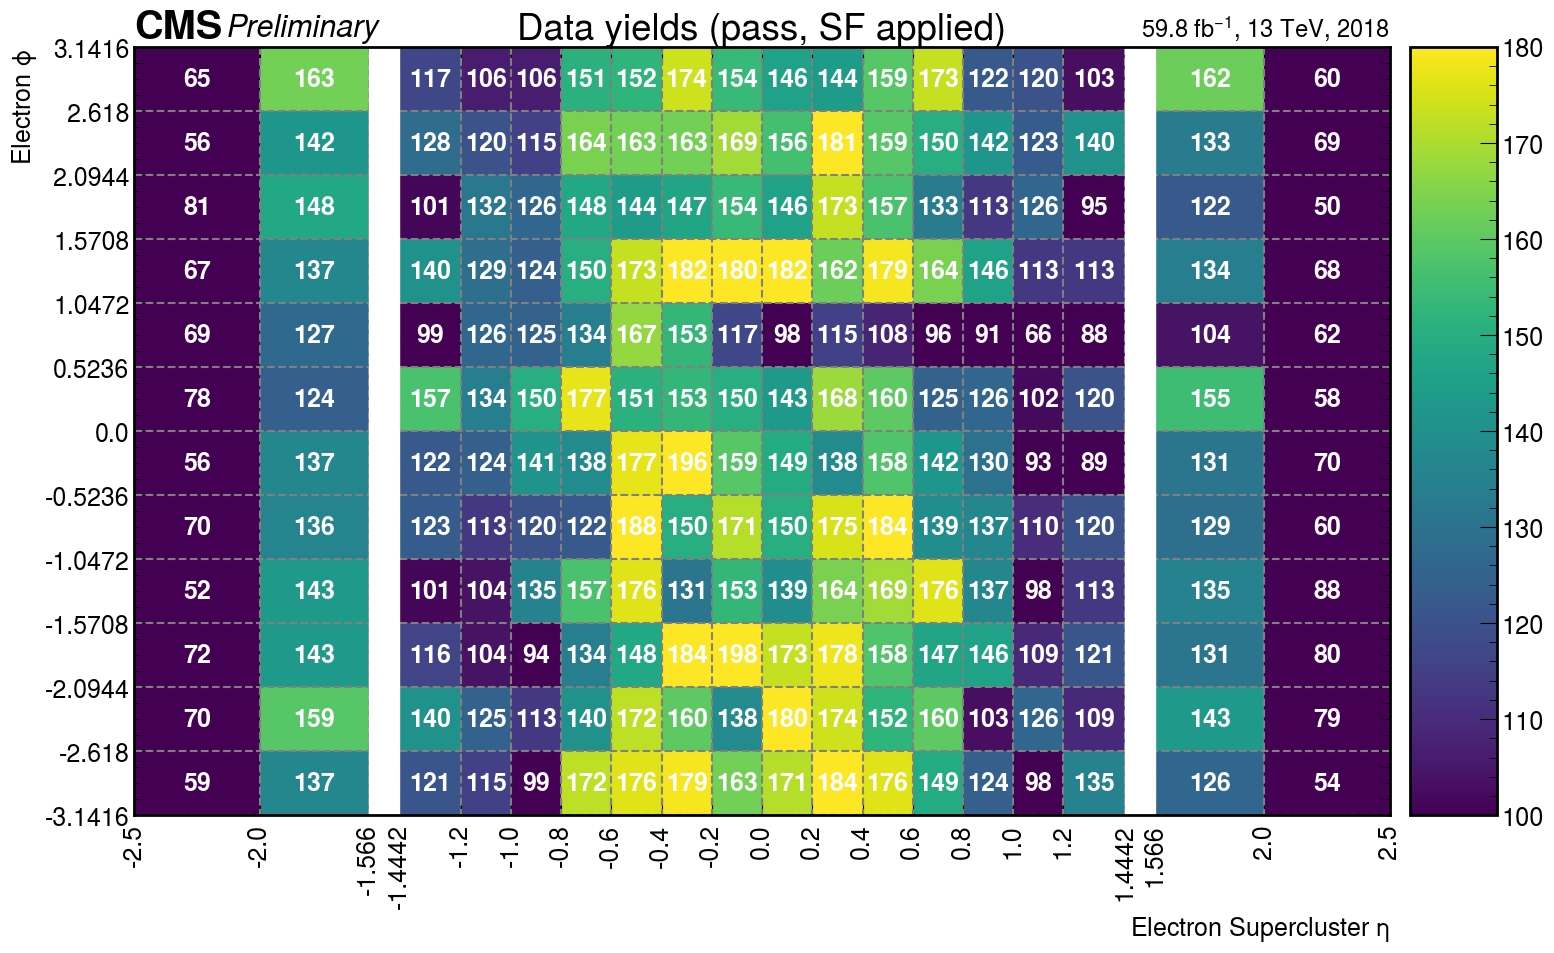

In [16]:
categories = ['mc_pass_sfapplied', 'data_pass_sfapplied']
for map2d, title, cat in zip([h_mc_sfapplied, h_data_sfapplied], ['MC yields (pass, SF applied)', 'Data yields (pass, SF applied)'], categories):
    file_plot = os.path.join(folder_plot, f"{histname}_yields_{cat}.png")
    yields[cat] = plot_yields(map2d, title, transpose=transpose[histname], vmin=vmin_dict[histname], vmax=vmax_dict[histname], file_plot=file_plot)